<a href="https://colab.research.google.com/github/vitorwogel/MVP/blob/main/MVP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Estudo sobre preços de ações de marcas concorrentes, sua possível correlação e a previsão de cotações futuras utilizando Redes Neurais Recorrentes</h1>

<h2>Definição do problema</h2>



O objetivo deste estudo é fazer uma análise sobre os preços de duas gigantes do mercado de <i>soft drinks</i> (inglês para bebidas não alcoólicas), Coca-Cola e Pepsi.<br>
Além disso o estudo busca utilizar de RNNs para a previsão destas séries temporais, tendo como variável alvo seu preço de fechamento (coluna <i>Close Price</i>) a cada dia.

As premissas iniciais sobre o problema são de que é possível prever com certa precisão os preços dessas ações desde que se tenha dados suficientes a um intervalo futuro de no mínimo 30 dias. Ademais, acredita-se inicialmente que possa haver algum tipo de correlação entre valores das duas marcas concorrentes.

Para selecionar o dataset, houveram alguns testes com outros conjuntos de dados provenientes do Kaggle, e foi então selecionado aquele que possuía dados mais longevos e consistentes, sem a necessidade de se realizar muito pré-processamento, pois o dataset já não contém valores nulos e, à primeira vista, não sofre com muitas anomalias.

<h3>Realizando os imports das bibliotecas a serem utilizadas</h3>

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation,Flatten
from keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
import datetime
import warnings

# Suprimir warnings
warnings.filterwarnings("ignore")

# Descrição do dataset

O objetivo nesta etapa será montar um novo dataset a partir de 2 originalmente selecionados com 6 features (*Date, Close Coca, Close Pepsi, Volume Coca, Volume Pepsi*) e dar inicio à análise exploratória.<br>
Os métodos utilizados nos próximos blocos de código servem para dar uma visão inicial sobre as colunas e tipos de dados que estamos lidando.

In [58]:
url_coca = 'https://raw.githubusercontent.com/vitorwogel/MVP/refs/heads/main/KO_stock_price.csv'
url_pepsi = 'https://raw.githubusercontent.com/vitorwogel/MVP/refs/heads/main/PEP_stock_price.csv'

coca = pd.read_csv(url_coca)
coca.head()

,Date,Open Price,High Price,Low Price,Close Price,Volume
0,1999-11-01,58.25,59.38,57.88,59.00,4212600.00
1,1999-11-02,58.63,58.94,57.31,57.75,3226800.00
2,1999-11-03,57.19,57.75,56.06,56.88,3958700.00
3,1999-11-04,57.50,57.50,56.06,56.69,3768500.00
4,1999-11-05,57.94,58.44,57.63,58.13,4104800.00


In [59]:
date_min_max = coca['Date'].min(), coca['Date'].max()
print(date_min_max)

('1999-11-01', '2024-11-01')


In [60]:
pepsi = pd.read_csv(url_pepsi)
pepsi.tail()

,Date,Open Price,High Price,Low Price,Close Price,Volume
6287,2024-10-28,172.98,172.98,169.72,169.84,5186635.00
6288,2024-10-29,169.20,169.20,166.97,167.50,5127890.00
6289,2024-10-30,167.00,167.64,166.08,166.21,4801541.00
6290,2024-10-31,166.10,167.50,165.81,166.08,5582423.00
6291,2024-11-01,166.09,166.25,165.21,165.59,6339121.00


In [61]:
date_min_max = pepsi['Date'].min(), pepsi['Date'].max()
print(date_min_max)

('1999-11-01', '2024-11-01')


In [62]:
print(coca.info())
print(pepsi.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6292 entries, 0 to 6291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         6292 non-null   object 
 1   Open Price   6292 non-null   float64
 2   High Price   6292 non-null   float64
 3   Low Price    6292 non-null   float64
 4   Close Price  6292 non-null   float64
 5   Volume       6292 non-null   float64
dtypes: float64(5), object(1)
memory usage: 295.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6292 entries, 0 to 6291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         6292 non-null   object 
 1   Open Price   6292 non-null   float64
 2   High Price   6292 non-null   float64
 3   Low Price    6292 non-null   float64
 4   Close Price  6292 non-null   float64
 5   Volume       6292 non-null   float64
dtypes: float64(5), object(1)
memory usage: 295.1+ KB
Non

In [63]:
print(coca.isna().sum())
print(pepsi.isna().sum())

Date           0
Open Price     0
High Price     0
Low Price      0
Close Price    0
Volume         0
dtype: int64
Date           0
Open Price     0
High Price     0
Low Price      0
Close Price    0
Volume         0
dtype: int64


Verificado que os dois datasets tem a mesma compreensão de data e não possuem valores ausentes em suas colunas, podemos fazer o <i>merge</i> para um único dataset.

In [64]:
coca = coca.rename(columns={'Close Price': 'Close Coca', 'Volume': 'Volume Coca'})
pepsi = pepsi.rename(columns={'Close Price': 'Close Pepsi', 'Volume': 'Volume Pepsi'})

In [65]:
df = pd.concat([coca[['Date', 'Close Coca', 'Volume Coca']],
                pepsi[['Close Pepsi', 'Volume Pepsi']]], axis=1)

Vamos passar o atributo 'Date' para o tipo 'datetime' e reordenar as colunas para melhor vizualização

In [66]:
df['Date'] = pd.to_datetime(df['Date'])

In [67]:
new_order = ['Date', 'Close Coca', 'Close Pepsi', 'Volume Coca', 'Volume Pepsi']

df = df[new_order]

In [68]:
# Mudar a configuracao global para exibir os numeros com 2 casas decimais

pd.options.display.float_format = '{:.2f}'.format

O método <i>describe</i> serve para nos fornecer as principais características dos dados numéricos do dataset, incluindo média, desvio padrão, min. e max., além dos quartis. Utilizaremos este método a seguir.

In [69]:
viz = df[['Close Coca', 'Close Pepsi', 'Volume Coca', 'Volume Pepsi']]

viz.describe()

,Close Coca,Close Pepsi,Volume Coca,Volume Pepsi
count,6292.00,6292.00,6292.00,6292.00
mean,50.61,89.54,10801777.40,5197253.99
std,8.97,42.59,6211032.08,2542187.84
min,35.97,30.50,1073700.00,772100.00
25%,43.33,54.95,6418250.00,3628089.50
50%,48.47,70.95,9885911.00,4634450.00
75%,57.05,115.38,13645305.50,6021150.00
max,81.12,196.12,98967500.00,34963700.00


Informações relevantes:


1.   A média do volume de transações da Coca-Cola é o dobro da Pepsi.
2.   O desvio padrão da cotação Pepsi é muito maior do que da Coca, isso indica uma variação nos dados discrepante entre uma empresa e outra, sendo uma teoricamente mais volátil e a outra mais constante.



Vamos plotar vizualizações gráficas do histórico dos preços dessas ações para complementar as informações iniciais.

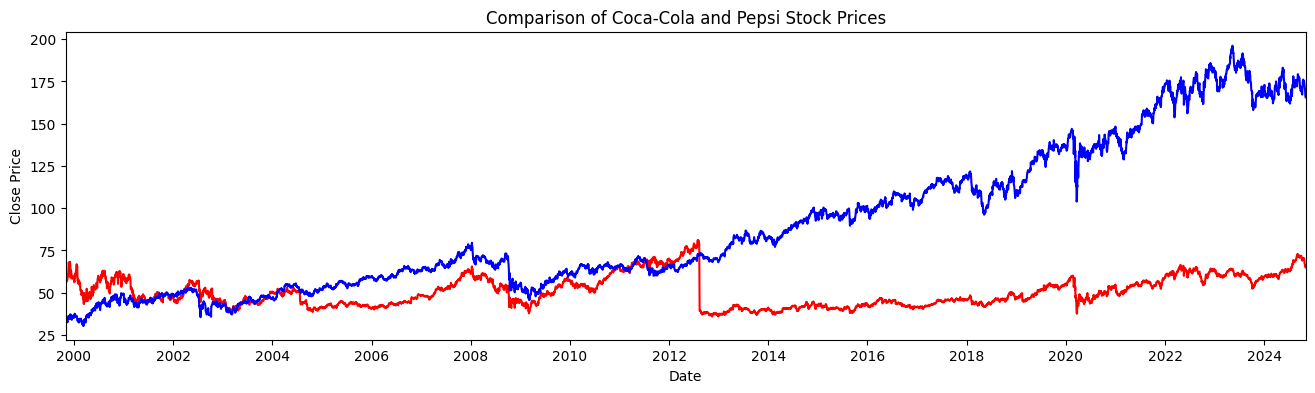

In [70]:
plt.figure(figsize=(16, 4))
plt.plot(df['Date'], df['Close Coca'], label='Coca-Cola', color='red')
plt.plot(df['Date'], df['Close Pepsi'], label='Pepsi', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Comparison of Coca-Cola and Pepsi Stock Prices')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

start_date = datetime.date(1999, 11, 1)
end_date = datetime.date(2024, 11, 1)

plt.xlim([start_date, end_date])
plt.show()

Conseguimos observar, a partir deste gráfico, que há uma queda brusca nos preços das ações da Coca-Cola ao final do ano de 2012, logo pode ser interessante dropar os dados anteriores a esta data, pois podem comprometer o desempenho das nossas RNNs.<br>
Antes de tomar esse tipo de decisão, vamos analisar como os dados dessas duas colunas se correlacionam em períodos anteriores e posteriores a este período.

In [71]:
treshold_date = datetime.datetime(2012, 8, 1, 0, 0, 0)
initial_date = datetime.datetime(2013, 1, 1, 0, 0, 0)

df_before = df[df['Date'] < treshold_date]
df_after = df[df['Date'] >= initial_date]

<h3>Correlação entre características</h3>

1. Com o dataset completo

In [72]:
correlacao = df['Close Coca'].corr(df['Close Pepsi'])

print(f'Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: {correlacao:.4f}')

Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: 0.2775


2. Com a metade anterior

In [73]:
correlacao = df_before['Close Coca'].corr(df_before['Close Pepsi'])

print(f'Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: {correlacao:.4f}')

Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: 0.4550


3. Com a metade posterior

In [74]:
correlacao = df_after['Close Coca'].corr(df_after['Close Pepsi'])

print(f'Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: {correlacao:.4f}')

Coeficiente de Correlação entre as ações da Coca-Cola e Pepsi: 0.9533


Chegamos a conclusão de que a metade posterior, tem uma correlação direta positiva muito maior entre os dados, além de ser a mais recente, portanto, iremos continuar nossa modelagem com este período do dataset.

In [75]:
df = df_after

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2980 entries, 3312 to 6291
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2980 non-null   datetime64[ns]
 1   Close Coca    2980 non-null   float64       
 2   Close Pepsi   2980 non-null   float64       
 3   Volume Coca   2980 non-null   float64       
 4   Volume Pepsi  2980 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 139.7 KB


In [77]:
start_date = df['Date'].min()
final_date = df['Date'].max()

print(f'Data inicial: {start_date}')
print(f'Data final: {final_date}')

Data inicial: 2013-01-02 00:00:00
Data final: 2024-11-01 00:00:00


# Preparação dos dados

Vamos começar a nossa preparação dos dados, utilizando-se da função MinMaxScaler do scikit-learn, que realiza a normalização das características numéricas.
Este método compreende os valores em uma faixa entre 0 e 1.

A normalização é benéfica em RNNs porque ajuda a estabilizar os gradientes durante o treinamento, acelera a convergência e melhora o desempenho ao evitar que valores muito grandes ou muito pequenos causem problemas de aprendizado, especialmente em sequências longas, como é o nosso caso.

In [78]:
scaler = MinMaxScaler()

def min_max_scaler(
    df,
    is_scaled,
    scaler,
):
  if is_scaled:
    return scaler.inverse_transform(df)
  df_scaled = scaler.fit_transform(df[['Close Coca', 'Close Pepsi']])
  dataset = pd.DataFrame(df_scaled, columns=['Close Coca', 'Close Pepsi'])
  return dataset

In [79]:
dataset = min_max_scaler(df, False, scaler)

Nesta etapa, utilizaremos de numpy arrays para organizar os dados no formato certo para o nosso modelo. Isso porque eles são rápidos, fáceis de manipular e já estão no formato que o modelo precisa para treinar corretamente.

In [80]:
def load_data(
    dataset,
    nb_samples,
    nb_test_samples,
    sequence_length,
    df_shape,
):
  Y = dataset.to_numpy(dtype=np.float32)

  X_ts = np.zeros(shape=(
          nb_samples - sequence_length,
          sequence_length,
          df_shape
        ),
        dtype=np.float32
      )
  Y_ts = np.zeros(shape=(
          nb_samples - sequence_length,
          df_shape
        ),
        dtype=np.float32
      )

  for i in range(0, nb_samples - sequence_length):
      X_ts[i] = Y[i:i + sequence_length]
      Y_ts[i] = Y[i + sequence_length]

  return X_ts, Y_ts

Como visto anteriormente, nosso conjunto de dados possui 2980 registros, vamos separar 20% desses dados para fins de validação (teste) e utilizar um período sequencial de 30 dias.<br>A escolha do período foi baseada em uma oscilação mensal da bolsa de valores.<br>Além disso, definimos também o formato do nosso dataset, que possui 2 entradas e 2 saídas.

In [81]:
nb_samples = 2980       # count total do df
nb_test_samples = 596   # 20% dos dados para teste
sequence_length = 30    # medida mensal
df_shape = 2            # 2 colunas (Close Coca e Close Pepsi)

X_ts, Y_ts = load_data(
    dataset,
    nb_samples,
    nb_test_samples,
    sequence_length,
    df_shape
)

A função abaixo realiza a alocação das respectivas sequências de treino e teste em seus numpy arrays.

In [82]:
def train_test_split(
    X_ts,
    Y_ts,
    nb_samples,
    nb_test_samples,
):
    X_ts_train = X_ts[0:nb_samples - nb_test_samples, :]
    Y_ts_train = Y_ts[0:nb_samples - nb_test_samples]

    X_ts_test = X_ts[nb_samples - nb_test_samples:, :]
    Y_ts_test = Y_ts[nb_samples - nb_test_samples:]

    return X_ts_train, Y_ts_train, X_ts_test, Y_ts_test

In [83]:
(
    X_ts_train,
    Y_ts_train,
    X_ts_test,
    Y_ts_test
) = train_test_split(
    X_ts,
    Y_ts,
    nb_samples,
    nb_test_samples,
)

# Modelagem e treinamento

É no trecho de código abaixo em que definimos nosso modelo, serão testados algumas variações do LSTM (*Long Short Term Memory*) que é uma rede neural muito utilizada na previsão de cotação de ações por sua capacidade de capturar dependências de longo prazo nos dados sequenciais, como as flutuações históricas dos preços, permitindo modelar tendências e padrões que influenciam os preços futuros.

Além do comprimento de sequência e do formato de nossa entrada, são passados mais 3 parâmetros para nossa função (perceptrons, hidden_layers e division) para que possamos controlar e experimentar dinâmicamente a montagem do modelo.<br>A característica division possui um valor padrão "1" e somente é passada se quisermos diminuir o número de neurônios em cada etapa.

In [84]:
def create_model(
    sequence_length,
    df_shape,
    perceptrons,
    hidden_layers,
    division = 1,
):
  if division < 1:
    raise ValueError("O valor de 'division' deve ser maior ou igual a 1.")

  model = Sequential()

  model.add(LSTM(perceptrons, return_sequences=True, input_shape=(sequence_length, df_shape)))

  new_value = int(perceptrons/division)

  if hidden_layers > 2:
    for i in range(hidden_layers-2):
      model.add(LSTM(new_value, return_sequences=True))
      new_value = int(new_value/division)

  model.add(LSTM(int(new_value/division)))

  # model.add(Dense(16, activation='relu')) # Exclusiva para o modelo 4
  model.add(Dense(df_shape, activation='linear'))

  return model

Nesta próxima função é definida a programação da taxa de aprendizado, uma técnica amplamente utilizada em redes neurais para ajustar dinamicamente a taxa de aprendizado ao longo do treinamento. Essa abordagem permite que o modelo comece com uma taxa de aprendizado maior para explorar rapidamente o espaço de soluções e, gradualmente, a reduza para estabilizar em uma solução ótima. Aqui, utilizamos a função ExponentialDecay para implementar esse ajuste de forma eficiente.

In [85]:
def compile_model(
    model,
):
    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,   # Taxa de aprendizado inicial
        decay_steps=1000,             # Quantos passos para o próximo ajuste
        decay_rate=0.9,               # Fator de redução da taxa de aprendizado
        staircase=True                # Decrescimento em passos discretos
    )

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='mse',
                  metrics=['mse'])

    return model

Agora,  realizamos o treinamento do modelo, ajustando os pesos através de várias épocas e utilizando um conjunto de validação para monitorar o desempenho em dados não vistos. Parâmetros como tamanho de lote e número de épocas são configurados para controlar o fluxo e a consistência do treinamento.

In [86]:
def train_model(
    model,
    X_ts_train,
    Y_ts_train,
    X_ts_test,
    Y_ts_test,
    batch_size,
):
  history = model.fit(
    X_ts_train, Y_ts_train,
    batch_size=batch_size, #para lotes de N em N
    epochs=100, # por 100 épocas
    shuffle=False, #sem embaralhar os dados de treinamento a cada época
    validation_data=(X_ts_test, Y_ts_test) #fazendo a validação com o conjunto separado para testes
  )

  return history

Por conta da ordem em que foram testados, o modelo que melhor performou e será utilizado nas outras etapas é chamado de "modelo 2".

<h3>Modelo 2:</h3>

Metricas utilizando 2 camadas LSTM, 16 perceptrons e 100 epocas de treinamento, considerando sequence_length de 30 dias:<br>
loss: 1.7657e-04 - mse: 1.7657e-04 - val_loss: 3.9670e-04 - val_mse: 3.9670e-04

In [87]:
model = create_model(
    sequence_length,
    df_shape,
    perceptrons=16,
    hidden_layers=2,
)

In [88]:
model = compile_model(model)

In [89]:
history = train_model(
    model,
    X_ts_train,
    Y_ts_train,
    X_ts_test,
    Y_ts_test,
    sequence_length,
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0086 - mse: 0.0086 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 9.2150e-04 - mse: 9.2150e-04 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/s

O mesmo modelo também foi treinado  considerando sequence_length de 21 dias:<br>
loss: 2.0988e-04 - mse: 2.0988e-04 - val_loss: 3.4885e-04 - val_mse: 3.4885e-04

# Testando outros parâmetros

Esta seção serve unicamente para mostrar que outros parâmetros também foram testados para nosso modelo LSTM.<br>Aqui serão referidos como modelos 1, 3 e 4, suas características e suas métricas também estão descritas nos blocos de texto.

<h3>Modelo 1:</h3>

Metricas utilizando 2 camadas LSTM, 8 perceptrons e 100 epocas de treinamento, considerando sequence_length de 30 dias:<br>
loss: 2.0012e-04 - mse: 2.0012e-04 - val_loss: 4.4284e-04 - val_mse: 4.4284e-04

In [90]:
model_1 = create_model(
    sequence_length,
    df_shape,
    perceptrons=8,
    hidden_layers=2,
)

In [91]:
model_1 = compile_model(model)

Para economizar tempo de execução a célula abaixo foi comentada.

In [92]:
# history_1 = train_model(
#     model,
#     X_ts_train,
#     Y_ts_train,
#     X_ts_test,
#     Y_ts_test,
#     sequence_length,
# )

Este mesmo modelo também foi treinado considerando sequence_length de 21 dias:<br>
loss: 2.8967e-04 - mse: 2.8967e-04 - val_loss: 5.2467e-04 - val_mse: 5.2467e-04

<h3>Modelo 3:</h3>

Metricas utilizando 4 camadas LSTM, 64 perceptrons e 100 epocas de treinamento, considerando um sequence_length de 30 dias:<br>
loss: 1.9151e-04 - mse: 1.9151e-04 - val_loss: 6.5900e-04 - val_mse: 6.5900e-04

In [93]:
model_3 = create_model(
    sequence_length,
    df_shape,
    perceptrons=64,
    hidden_layers=4,
)

In [94]:
model_3 = compile_model(model)

Para economizar tempo de execução a célula abaixo foi comentada.

In [95]:
# history_3 = train_model(
#     model,
#     X_ts_train,
#     Y_ts_train,
#     X_ts_test,
#     Y_ts_test,
#     sequence_length,
# )

Este mesmo modelo também foi testado considerando sequence_length de 63 dias:<br>
loss: 4.4837e-04 - mse: 4.4837e-04 - val_loss: 5.4921e-04 - val_mse: 5.4921e-04

<h3>Modelo 4:</h3>

Metricas utilizando 3 camadas LSTM, respectivamente 128, 64 e 32 perceptrons, alem de 2 camadas densas, a primeira com 16 neuronios e ativacao relu e a segunda (saida) com 2 e ativacao linear, consideranco um sequence_length de 30 dias:<br>
loss: 2.8448e-04 - mse: 2.8448e-04 - val_loss: 8.2682e-04 - val_mse: 8.2682e-04


In [96]:
model_4 = create_model(
    sequence_length,
    df_shape,
    perceptrons=128,
    hidden_layers=3,
    division=2
)

In [97]:
model_4 = compile_model(model)

Para economizar tempo de execução a célula abaixo foi comentada.

In [98]:
# history_4 = train_model(
#     model,
#     X_ts_train,
#     Y_ts_train,
#     X_ts_test,
#     Y_ts_test,
#     sequence_length,
# )

O mesmo modelo também foi testado consideranco um sequence_length de 63 dias:<br>
loss: 3.4154e-04 - mse: 3.4154e-04 - val_loss: 5.5775e-04 - val_mse: 5.5775e-04

# Avaliação de resultados

O modelo que se saiu melhor com as métricas definidas durante o treinamento para o conjunto de validação foi o "modelo 2", portanto iremos continuar a análise de resultados com ele, caso as outras métricas não sejam satisfatórias, poderemos testar outros modelos.

Agora vamos analisar outras métricas, como MAE, RMSE e R². Essas métricas fazem sentido para a análise de desempenho de RNNs, pois avaliam erros absolutos, a raiz do erro médio quadrático e a proporção de variabilidade explicada pelo modelo, fornecendo uma visão abrangente da qualidade das previsões.

Abaixo, definições sobre essas métricas:


*   MAE (Mean Absolute Error): Quanto menor, melhor, indicando previsões mais próximas dos valores reais.
*   RMSE (Root Mean Squared Error): Quanto menor, melhor, destacando o
impacto de grandes erros.
*   R² (Coeficiente de Determinação): Mais próximo de 1, melhor, indicando que o modelo explica a maior parte da variância nos dados.



In [99]:
from sklearn.metrics import mean_squared_error, r2_score

y_true = Y_ts_test
y_pred = model.predict(X_ts_test)  # Previsões do modelo no conjunto de teste

# 1. RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

# 2. SMAPE (Symmetric Mean Absolute Percentage Error)
smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
print(f"SMAPE: {smape:.4f}")

# 3. R² (Coeficiente de Determinação)
r2 = r2_score(y_true, y_pred)
print(f"R²: {r2:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
RMSE: 0.0187
SMAPE: 1.9832
R²: 0.9351


Comparado a problemas similares, as métricas RMSE, SMAPE e R² indicam que o modelo apresenta erros baixos, boa precisão percentual e explica bem a variabilidade dos dados, mostrando-se eficaz dentro do contexto analisado.

Plotamos 2 gráficos para analisar o desempenho do modelo de acordo com as épocas de treinamento, tanto para o conjunto de treino quanto de teste.

In [100]:
def plot_metrics(
    history
):
  # plotamos o erro calculado a partir do histórico
  plt.plot(history.history['mse'])  # erro médio quadrático (treinamento)
  plt.plot(history.history['val_mse']) # erro médio quadrático (teste)
  plt.title('MSE do Modelo')
  plt.ylabel('mse')
  plt.xlabel('época')
  plt.legend(['treino', 'teste'], loc='upper left')
  plt.show()

  # plotamos o erro/perda a partir do histórico
  plt.plot(history.history['loss']) # perda/erro durante o treinamento
  plt.plot(history.history['val_loss']) #perda/erro durante a validação (teste)
  plt.title('Perda do modelo')
  plt.ylabel('perda')
  plt.xlabel('época')
  plt.legend(['treino', 'teste'], loc='upper left')
  plt.show()

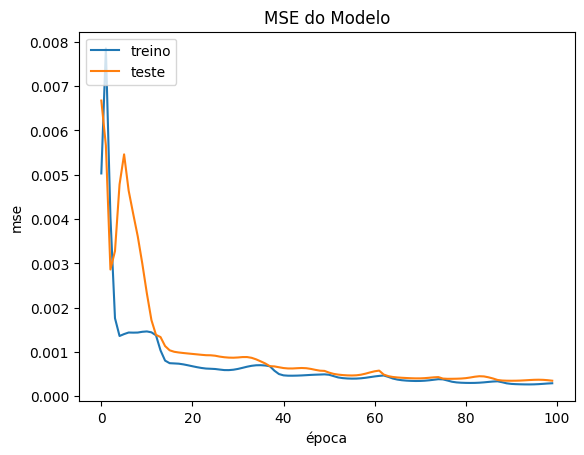

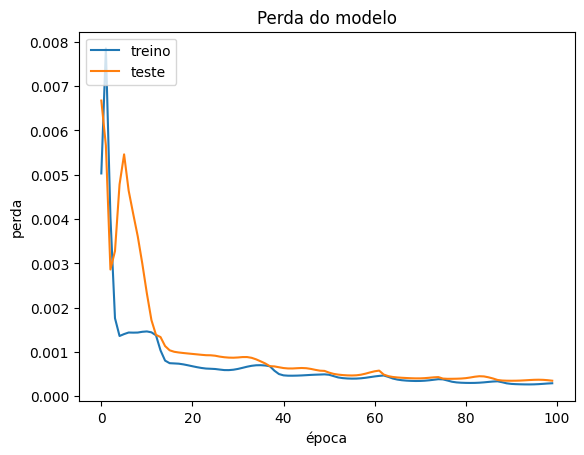

In [101]:
plot_metrics(history)

Não se tratando de um custo computacional tão alto, por ter apenas 2 camadas ocultas com 16 neurônios cada uma, escolhemos continuar com o treinamento durante 100 épocas.

Vamos plotar um gráfico que nos fornece a visão de como o algoritmo se comportou em relação a dados reais.<br>
Para isso fizemos uma função para comparar as linhas real vs previsto das duas saídas.<br>
Faremos isso tanto para dados de treino, como dados de teste.

In [102]:
def plot_real_vs_predicted(
    model,
    sequence_length,
    X_ts_train: np.ndarray | None = None,
    Y_ts_train: np.ndarray | None = None,
    X_ts_test: np.ndarray | None = None,
    Y_ts_test: np.ndarray | None = None,
):
  # Predições do modelo
  predictions = model.predict(
    X_ts_train if X_ts_train is not None else X_ts_test,
    batch_size=sequence_length
  )

  # Criando o gráfico único
  plt.figure(figsize=(16, 4))

  # Plotando Close Coca real vs Close Coca predições
  plt.plot(Y_ts_train[:, 0], label='Dado Real - Close Coca')
  plt.plot(predictions[:, 0], label='Predição - Close Coca')

  # Plotando Close Pepsi real vs Close Pepsi predições
  plt.plot(Y_ts_train[:, 1], label='Dado Real - Close Pepsi')
  plt.plot(predictions[:, 1], label='Predição - Close Pepsi')

  # Ajustes para uma apresentação clara
  plt.legend()
  plt.title('Dados Reais vs Predições para Close Coca e Close Pepsi')
  plt.xlabel('Passos de Tempo')
  plt.ylabel('Preço')
  plt.show()

Faremos primeiro para treino

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


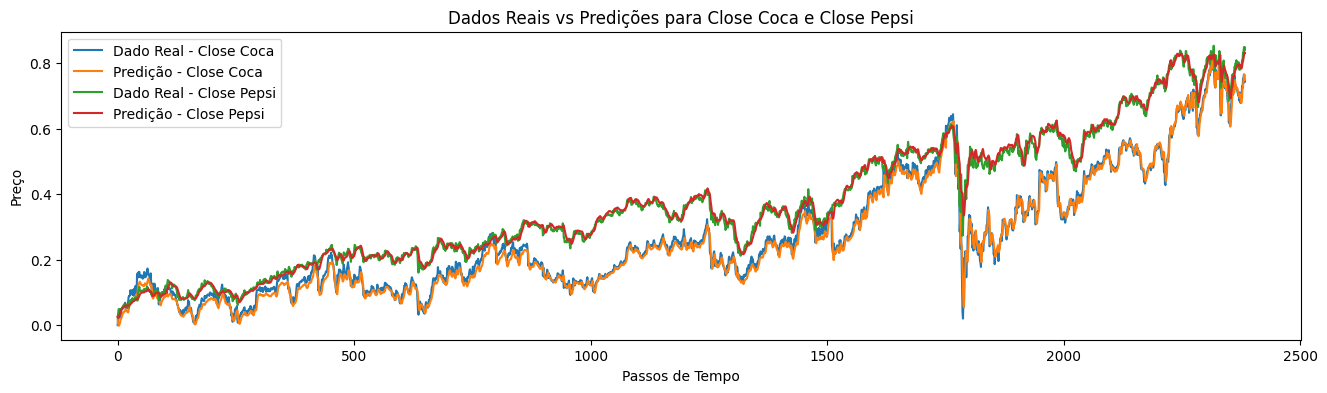

In [103]:
plot_real_vs_predicted(
    model,
    sequence_length,
    X_ts_train,
    Y_ts_train,
)

As previsões estão muito próximas do real, será que há overfitting?<br>
Para responder essa pergunta iremos plotar o gráfico com o conjunto de testes.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


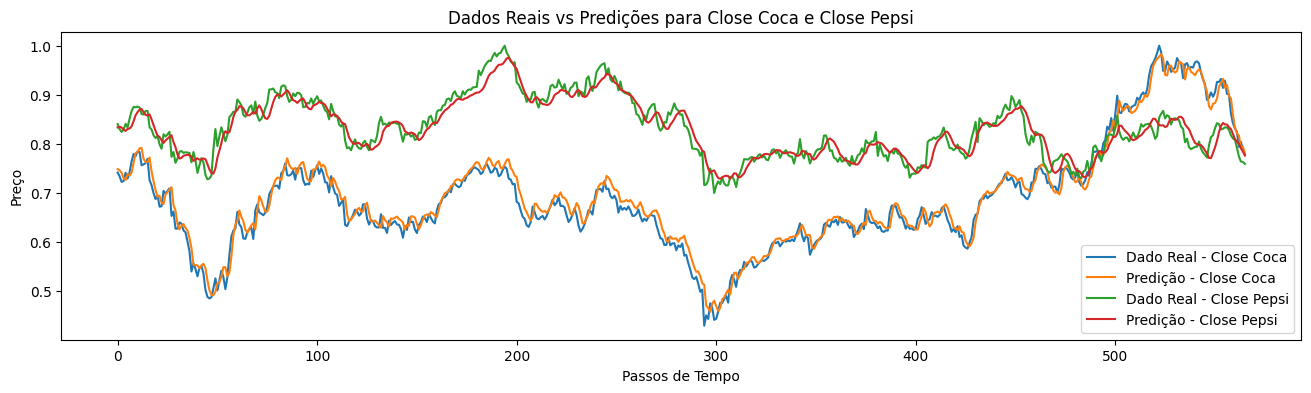

In [104]:
plot_real_vs_predicted(
    model,
    sequence_length,
    X_ts_test,
    Y_ts_test,
)

As previsões, a pesar de não acertarem tudo (o que já era esperado), parecem satisfatórias.

# Previsão futura

Nesta etapa iremos treinar o modelo com todo o conjunto de dados (treino + teste) e deixá-lo pronto para produção.<br>
A partir disso vamos estimar um período futuro de X dias para verificar qual será a previsão futura que nosso modelo oferece.

In [134]:
model.fit(
    X_ts, Y_ts,
    batch_size=30, #para lotes de N em N
    epochs=100, # por 100 épocas
    shuffle=False, #sem embaralhar os dados de treinamento a cada época
  )

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 2.4981e-04 - mse: 2.4981e-04
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.0731e-04 - mse: 4.0731e-04
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 5.7170e-04 - mse: 5.7170e-04
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.7726e-04 - mse: 4.7726e-04
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8555e-04 - mse: 2.8555e-04
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.0123e-04 - mse: 2.0123e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.8195e-04 - mse: 1.8195e-04
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.7715e-04 - mse: 1.7715e-04
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.7433e-04 - mse: 1.7433e-04
Epoch 10/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.7236e-04 - mse: 1.7236e-04
Epoch 11/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6961e-04 - mse: 1.6961e-04
Epoch 12/100
99/99 

In [135]:
def future_prediction(
    X_ts,
    Y_ts,
    model,
    dias_a_prever,
    df_shape,
):
  ultima_sequencia = X_ts[-1:]

  previsoes_futuras = []

  for _ in range(dias_a_prever):
      previsao = model.predict(ultima_sequencia)
      previsoes_futuras.append(previsao[0])

      ultima_sequencia = np.concatenate(
        [ultima_sequencia[:, 1:, :], previsao.reshape(1, 1, df_shape)],
        axis=1
      )

  return previsoes_futuras

In [136]:
dias_a_prever = 30

previsoes_futuras = future_prediction(
    X_ts,
    Y_ts,
    model,
    dias_a_prever,
    df_shape,
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

Faremos também o plot dessa previsão.

In [137]:
def plot_future_prediction(
    Y_ts_test,
    scaler,
    previsoes_futuras,
):
  Y_ts_test = scaler.inverse_transform(Y_ts_test)
  previsoes_futuras = scaler.inverse_transform(previsoes_futuras)

  plt.figure(figsize=(16, 4))

  plt.plot(Y_ts_test[:, 0], label='Dados Reais - Close Coca')
  plt.plot(np.arange(len(Y_ts_test), len(Y_ts_test) + len(previsoes_futuras)), previsoes_futuras[:, 0], label='Previsão - Close Coca')

  plt.plot(Y_ts_test[:, 1], label='Dados Reais - Close Pepsi')
  plt.plot(np.arange(len(Y_ts_test), len(Y_ts_test) + len(previsoes_futuras)), previsoes_futuras[:, 1], label='Previsão - Close Pepsi')

  plt.legend()
  plt.xlabel('Passos de Tempo')
  plt.ylabel('Preço')
  plt.title('Previsões Futuras vs Dados Reais para Close Coca e Close Pepsi')
  plt.show()

  return previsoes_futuras

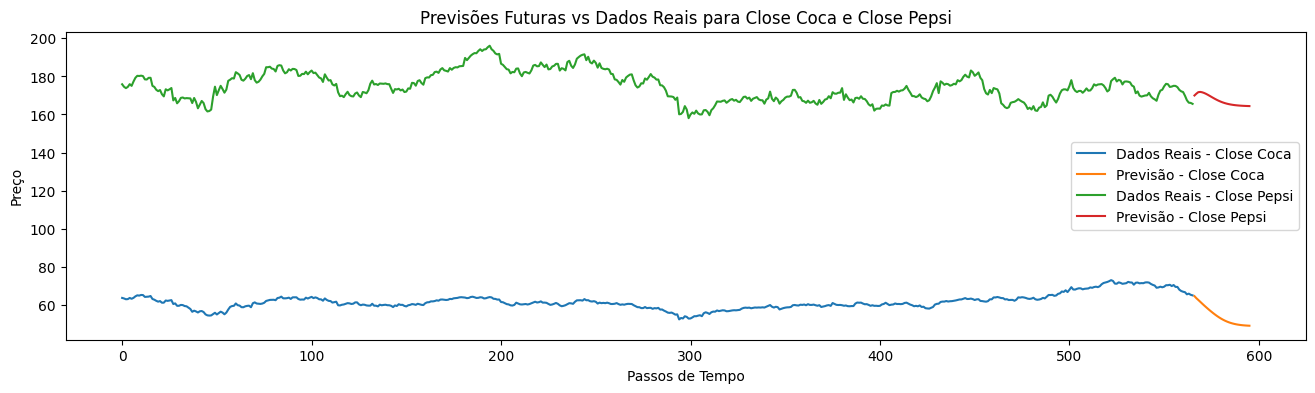

In [138]:
previsoes_scaled = plot_future_prediction(Y_ts_test, scaler, previsoes_futuras)

Agora que já foi possível vizualizar no gráfico o que o modelo desenha para os próximos dias, vamos imprimir os valores de forma numérica e realizar alguns cálculos para que possamos informar a nossos usuários se vale a pena ou não comprar alguma das ações indicadas.

In [139]:
ultima_sequencia = X_ts_test[-1]  # pega a última sequência de teste

ultima_sequencia_original = scaler.inverse_transform(ultima_sequencia)

ultima_sequencia_coca = ultima_sequencia_original[-1, 0]  # Último valor da variável Close Coca
ultima_sequencia_pepsi = ultima_sequencia_original[-1, 1]  # Último valor da variável Close Pepsi

# Exibindo os resultados no console
print(f"Último preço de Close Coca: {ultima_sequencia_coca}")
print(f"Último preço de Close Pepsi: {ultima_sequencia_pepsi}")

Último preço de Close Coca: 65.31000518798828
Último preço de Close Pepsi: 166.0800018310547


In [140]:
# Última previsão para Close Coca e Close Pepsi
ultimo_valor_previsoes = previsoes_scaled[-1]

# Fechando as previsões em números individuais
close_coca_previsao = ultimo_valor_previsoes[0]
close_pepsi_previsao = ultimo_valor_previsoes[1]

# Exibindo os resultados no console
print(f"Última previsão para Close Coca: {close_coca_previsao}")
print(f"Última previsão para Close Pepsi: {close_pepsi_previsao}")

Última previsão para Close Coca: 49.067379811704164
Última previsão para Close Pepsi: 164.41830571353435


In [141]:
diferenca_coca = close_coca_previsao - ultima_sequencia_coca
diferenca_pepsi = close_pepsi_previsao - ultima_sequencia_pepsi

percent_coca = (diferenca_coca / ultima_sequencia_coca) * 100
percent_pepsi = (diferenca_pepsi / ultima_sequencia_pepsi) * 100

print(f"Diferença percentual Close Coca: {percent_coca:.2f}%")
print(f"Diferença percentual Close Pepsi: {percent_pepsi:.2f}%")

Diferença percentual Close Coca: -24.87%
Diferença percentual Close Pepsi: -1.00%


In [142]:
acao_a_comprar = "Coca-Cola" if percent_coca > percent_pepsi else "Pepsi"
melhor_valor = percent_coca if acao_a_comprar == "Coca-Cola" else percent_pepsi
pior_valor = percent_pepsi if acao_a_comprar == "Coca-Cola" else percent_coca

lucro = (melhor_valor - pior_valor) if pior_valor > 0 else (melhor_valor - 0)

comprar_ou_nao = (
    f"comprar ações da {acao_a_comprar}" if lucro > 0
    else "não comprar ações de nenhuma das empresas"
)

justificativa = (
    f"pois o lucro sera maior em {lucro:.2f}%" if lucro > 0
    else f"pois terá prejuízo na compra das duas ações."
)

print(f"""A ação a ser tomada é {comprar_ou_nao}, no próximo período de
{dias_a_prever} dias, {justificativa}""")

A ação a ser tomada é não comprar ações de nenhuma das empresas, no próximo período de
30 dias, pois terá prejuízo na compra das duas ações.


# Conclusão

Este MVP teve como objetivo comparar preços de ações de duas das maiores produtoras de refrigerantes do planeta (Coca-Cola e Pepsi) para assim criar um modelo de rede neural que fosse capaz de ofertar aos usuários a possibilidade de uma previsão futura dessas cotações.<br>



Durante o trabalho, foi possível descobrir que as ações das duas empresas estão altamente correlacionadas no ano de 2013 até 2024, portanto decidimos trabalhar com esse período do dataset, com isso foi possível também evitar a anomalia que aconteceu no ano de 2012, onde os preços das ações da Coca-Cola caíram bruscamente em um período curto de tempo.

Durante a modelagem a arquitetura escolhida foi a LSTM, dado que esta é amplamente utilizada em problemas de séries temporais, como este, principalmente no mercado financeiro. Apesar de o modelo já ter se saído bem logo nos primeiros treinamentos, foi importante testar outros métodos, como a inserção de mais camadas na rede e a variação do número de neurônios. Ao fim chegou-se a conclusão que um dos modelos mais simples testados (com apenas 2 camadas ocultas e 16 neurônios em cada uma) foi o mais eficaz, trazendo melhores métricas e sendo também um dos menos custosos.

Após a avaliação dos resultados e a escolha do modelo ideal, ainda foi proposta uma etapa de "previsão futura", onde treinamos o modelo com todo o dataset, incluindo os dados de teste, fazendo com que ficasse pronto para produção.

Ao final foi fornecido de maneira exemplificada ao usuário um print na tela em que era informado qual ação ele poderia comprar, com base no período futuro indicado.

Portanto, chega-se a conclusão que realmente foi possível treinar uma Rede Neural Recorrente (arquitetura LSTM) para prever de forma estimada os preços futuros (em um intervalo de 30 dias) de ações de marcas concorrentes, utilizando-se da correlação estabelicida entre elas para aprimorar o treinamento.